In [1]:
#random Forest with manual advnaced preprocessed dataset


In [2]:
import numpy as np
import pandas as pd
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import randint

RESULTS_DIR = r'C:/Users/Welcome/OneDrive - NSBM/Desktop/3rd_year/flight delay/flight-delay-prediction-ml/flight-delay-prediction-ml/results'


In [3]:
# advanced preprocessed features (full dataset, not split)
X_adv = pd.read_csv(os.path.join(RESULTS_DIR, 'processed_features_advanced.csv')).values
y_adv = pd.read_csv(os.path.join(RESULTS_DIR, 'target_advanced.csv'))['arr_delay'].values

# Train-test split 
X_train_adv_s, X_test_adv_s, y_train_adv_s, y_test_adv_s = train_test_split(
    X_adv, y_adv, test_size=0.2, random_state=42, stratify=y_adv
)

X_train_adv_s.shape, X_test_adv_s.shape


((80000, 9), (20000, 9))

In [4]:
# baseline RF with default params
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base.fit(X_train_adv_s, y_train_adv_s)

y_pred_base = rf_base.predict(X_test_adv_s)
y_proba_base = rf_base.predict_proba(X_test_adv_s)[:, 1]

print("Baseline RF:")
print("  Accuracy:", accuracy_score(y_test_adv_s, y_pred_base))
print("  F1      :", f1_score(y_test_adv_s, y_pred_base))
print("  ROC-AUC :", roc_auc_score(y_test_adv_s, y_proba_base))


Baseline RF:
  Accuracy: 0.8155
  F1      : 0.33989266547406083
  ROC-AUC : 0.7157943681326198


In [5]:
#RF hyperparameter ranges
param_dist = {
    'n_estimators': randint(100, 400),      # number of trees
    'max_depth': randint(5, 40),           # tree depth
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
}


In [6]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,          # 30 random tries – good balance of time vs quality
    scoring='f1',       # focus on F1 because delays are the minority class
    cv=3,               # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train_adv_s, y_train_adv_s)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': <scipy.stats....002189E27A350>, 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': <scipy.stats....002189E2B29E0>, ...}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [7]:
print("Best parameters from RandomizedSearchCV:")
print(rf_random.best_params_)

best_rf = rf_random.best_estimator_

y_pred_tuned = best_rf.predict(X_test_adv_s)
y_proba_tuned = best_rf.predict_proba(X_test_adv_s)[:, 1]

print("\nTuned RF:")
print("  Accuracy:", accuracy_score(y_test_adv_s, y_pred_tuned))
print("  F1      :", f1_score(y_test_adv_s, y_pred_tuned))
print("  ROC-AUC :", roc_auc_score(y_test_adv_s, y_proba_tuned))


Best parameters from RandomizedSearchCV:
{'bootstrap': False, 'max_depth': 32, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 367}

Tuned RF:
  Accuracy: 0.7877
  F1      : 0.35274390243902437
  ROC-AUC : 0.6589765658716529


In [20]:
import joblib

joblib.dump(best_rf, os.path.join(RESULTS_DIR, 'best_random_forest_advanced.pkl'))
print("Saved tuned RF model to disk.")


Saved tuned RF model to disk.


In [9]:

#xgboost

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import randint, uniform


In [11]:
# Baseline XGBoost (simple, untuned)
xgb_base = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_base.fit(X_train_adv_s, y_train_adv_s)
y_pred_xgb_base = xgb_base.predict(X_test_adv_s)
y_proba_xgb_base = xgb_base.predict_proba(X_test_adv_s)[:, 1]

print("Baseline XGBoost:")
print("  Accuracy:", accuracy_score(y_test_adv_s, y_pred_xgb_base))
print("  F1      :", f1_score(y_test_adv_s, y_pred_xgb_base))
print("  ROC-AUC :", roc_auc_score(y_test_adv_s, y_proba_xgb_base))


Baseline XGBoost:
  Accuracy: 0.82505
  F1      : 0.31646806016800155
  ROC-AUC : 0.7388161415187382


In [12]:
# Rough estimate of class imbalance for scale_pos_weight
pos_ratio = y_train_adv_s.mean()
scale_pos = (1 - pos_ratio) / pos_ratio
scale_pos


np.float64(4.043182247998487)

In [13]:
param_dist_xgb = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),        # 0.6–1.0
    'colsample_bytree': uniform(0.6, 0.4), # 0.6–1.0
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 5),
    'scale_pos_weight': [1, scale_pos]     # try no-weight vs imbalance-aware
}


In [14]:
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,          # similar to RF tuning
    scoring='f1',       # same focus: F1 on delays
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train_adv_s, y_train_adv_s)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....002189EB15950>, 'gamma': <scipy.stats....002189EADD480>, 'learning_rate': <scipy.stats....002189E33BB60>, 'max_depth': <scipy.stats....002189EAE67B0>, ...}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [15]:
print("Best XGBoost params:")
print(xgb_random.best_params_)

best_xgb = xgb_random.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_test_adv_s)
y_proba_xgb_tuned = best_xgb.predict_proba(X_test_adv_s)[:, 1]

print("\nTuned XGBoost:")
print("  Accuracy:", accuracy_score(y_test_adv_s, y_pred_xgb_tuned))
print("  F1      :", f1_score(y_test_adv_s, y_pred_xgb_tuned))
print("  ROC-AUC :", roc_auc_score(y_test_adv_s, y_proba_xgb_tuned))


Best XGBoost params:
{'colsample_bytree': np.float64(0.9630265895704372), 'gamma': np.float64(1.2464611457443748), 'learning_rate': np.float64(0.09207658460712595), 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 112, 'scale_pos_weight': np.float64(4.043182247998487), 'subsample': np.float64(0.8395461865954144)}

Tuned XGBoost:
  Accuracy: 0.70725
  F1      : 0.45992067152476707
  ROC-AUC : 0.7489606601227057


In [16]:
#xgboost features importance

In [18]:
df_adv = pd.read_csv(os.path.join(RESULTS_DIR, 'processed_features_advanced.csv'))
X_adv = df_adv.values  
feature_names = df_adv.columns



<Figure size 800x1000 with 0 Axes>

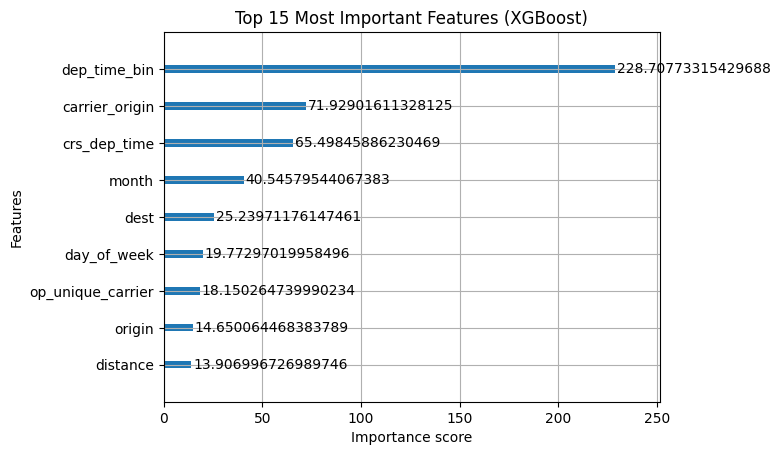

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

best_xgb.get_booster().feature_names = list(feature_names)

plt.figure(figsize=(8, 10))
plot_importance(best_xgb, importance_type='gain', max_num_features=15)
plt.title('Top 15 Most Important Features (XGBoost)')
plt.show()


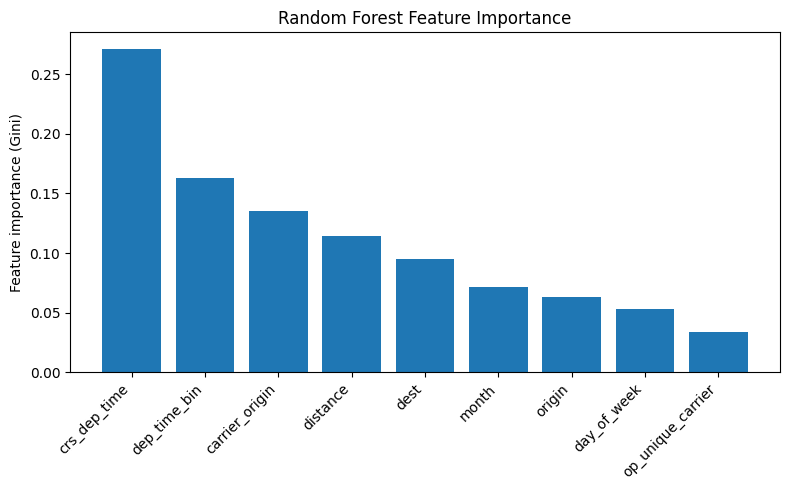

In [21]:
import numpy as np
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)),
           np.array(feature_names)[indices],
           rotation=45, ha='right')
plt.ylabel('Feature importance (Gini)')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


In [23]:
The XGBoost model mainly focuses on when a flight is scheduled and where it operates.
Features like the time of day, exact departure time,
origin and destination airports,
and the airline–route combination play the biggest role in predicting delays. 
This suggests the model has learned that 
delay risk is strongly influenced by congestion at certain times 
and by how specific airlines operate at particular airports. 
These findings make sense in real life, 
since busy periods and airport-specific practices often lead to delays.

In [ ]:
The Random Forest model highlights a very similar pattern to XGBoost.
Time-related features, such as the exact scheduled departure time 
and broader time-of-day bins, are the most important, 
followed by route- and airline-related factors like the operating carrier, 
flight distance, and destination airport. 
This consistency across both models shows that timing 
and specific airline–route combinations are key drivers of delay risk.
Overall, it suggests that arrival delays can be predicted 
quite well using only pre-flight information,
without needing detailed delay reasonsafter the flight has already occurred.

In [24]:
#Confusion matrices: tuned RF vs tuned XGBoost

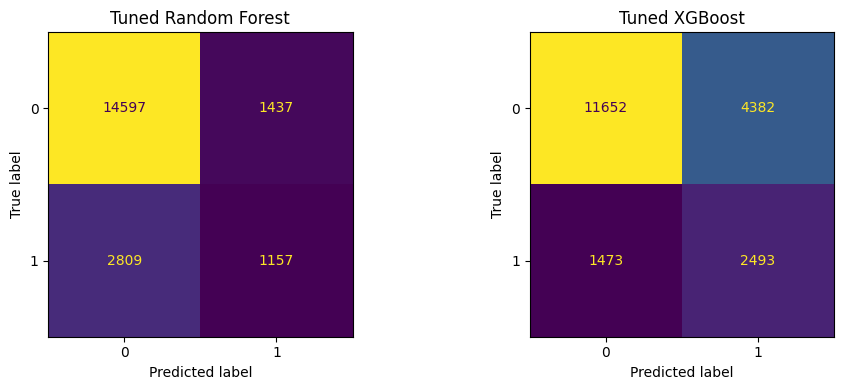

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_rf  = best_rf.predict(X_test_adv_s)
y_pred_xgb = best_xgb.predict(X_test_adv_s)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, y_pred, title in zip(
    axes,
    [y_pred_rf, y_pred_xgb],
    ['Tuned Random Forest', 'Tuned XGBoost']
):
    cm = confusion_matrix(y_test_adv_s, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(ax=ax, colorbar=False, values_format='d')
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [26]:
#Metric comparison table

In [27]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

y_proba_rf  = best_rf.predict_proba(X_test_adv_s)[:, 1]
y_proba_xgb = best_xgb.predict_proba(X_test_adv_s)[:, 1]

results = pd.DataFrame({
    'model':    ['RF_tuned', 'XGB_tuned'],
    'accuracy': [
        accuracy_score(y_test_adv_s, y_pred_rf),
        accuracy_score(y_test_adv_s, y_pred_xgb)
    ],
    'f1': [
        f1_score(y_test_adv_s, y_pred_rf),
        f1_score(y_test_adv_s, y_pred_xgb)
    ],
    'roc_auc': [
        roc_auc_score(y_test_adv_s, y_proba_rf),
        roc_auc_score(y_test_adv_s, y_proba_xgb)
    ]
})
results


,model,accuracy,f1,roc_auc
0,RF_tuned,0.78770,0.352744,0.658977
1,XGB_tuned,0.70725,0.459921,0.748961


In [29]:
 when its come to accuracy RF looks better, the dataset is imbalanced(many non delyas), 
so a model can get high accuracy mainly by saying "No delay" most of the time. 

F1 focuses on the positive class(delays=1). XGB’s higher F1 means it is much better 
at actually catching delayed flights while keeping false alarms at a reasonable level. 

ROC‑AUC measures how well the model ranks 
delayed vs on‑time flights across all thresholds. 
XGB’s 0.75 vs RF’s 0.66 means XGB is clearly better 
at separating risky flights from safe ones.



In [ ]:
Connecting this to your confusion matrices:

RF:

Many true negatives (on‑time correctly), but misses a lot of delays (many false negatives).

XGB:

Catches more than double the number of true delayed flights, but also increases false positives (more flights flagged as delayed that are actually on time).